In [1]:
import os 
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

Using TensorFlow backend.


In [2]:
#import the data 
os.chdir("./data")

def read_data(file_name):
    labels = []
    titles = []
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'BillID' not in line:
                split = line.split("\t")
                label = split[-1].rstrip("\n")
                if label == "23":
                    label = "11"
                labels.append(label)
                title = split[-2].replace('"', "").replace(",", "").replace(".", "").lower()
                titles.append(title)
                
    return (titles, np.asarray(labels))

train_titles_raw, train_labels_raw = read_data("congress_train.txt")
val_titles_raw, val_labels_raw = read_data("congress_val.txt")
test_titles_raw, test_labels_raw = read_data("congress_test.txt")

In [5]:
#check the data length 

print (len(train_titles_raw), len(train_labels_raw))
print (len(val_titles_raw), len(val_labels_raw))
print (len(test_titles_raw), len(test_labels_raw))

278612 278612
69649 69649
38693 38693


In [3]:
#setting up_data
maxlen = 100
max_words = 10000

#training data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_titles_raw)
training_sequences = tokenizer.texts_to_sequences(train_titles_raw)
word_index = tokenizer.word_index
x_train = pad_sequences(training_sequences, maxlen=100)

#validation
val_sequences = tokenizer.texts_to_sequences(val_titles_raw)
x_val = pad_sequences(val_sequences, maxlen=100)

#test
test_sequences = tokenizer.texts_to_sequences(test_titles_raw)
x_test = pad_sequences(test_sequences, maxlen =100)


y_train = to_categorical(train_labels_raw)
y_val = to_categorical(val_labels_raw)
y_test = to_categorical(test_labels_raw)


### Estimate a basic feed-forward network

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

basic_model = Sequential()

# output dim = 32
basic_model.add(Embedding(10000, 24, input_length = 100))
basic_model.add(Flatten())
basic_model.add(Dense(22, activation='softmax'))

basic_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
basic_model.summary()

history = basic_model.fit(x_train, y_train, 
                          epochs= 20, 
                          batch_size= 1024,
                         validation_data = (x_test, y_test))
basic_model.save('basic_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 24)           240000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                52822     
Total params: 292,822
Trainable params: 292,822
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 278612 samples, validate on 38693 samples
Epoch 1/20
278612/278612 [==============================] - 3s 11us/step - loss: 2.2052 - acc: 0.3871 - val_loss: 1.4756 - val_acc: 0.6205
Epoch 2/20
278612/278612 [==============================] - 2s 7us/step - loss: 1.1091 - a

In [ ]:
basic_model.evaluate(x_val, y_val)

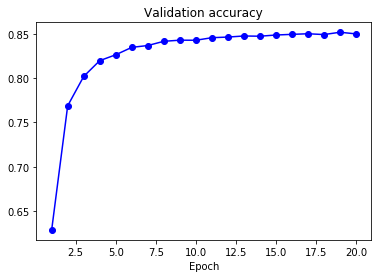

<Figure size 432x288 with 0 Axes>

In [8]:
basic_val_acc = history.history['val_acc']
basic_val_loss = history.history['val_loss']

epochs = range(1, len(basic_val_acc) + 1)

plt.plot(epochs, basic_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

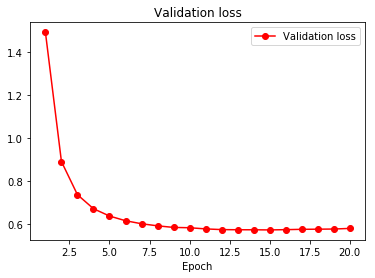

In [9]:
plt.clf()
plt.plot(epochs, basic_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Estimate a recurrent neural network (RNN) with a layer_simple_rnn

In [10]:
from keras.layers import SimpleRNN

simple_rnn = Sequential()
simple_rnn.add(Embedding(10000, 24, input_length = 100))
simple_rnn.add(SimpleRNN(24))
simple_rnn.add(Dense(22, activation='softmax'))

simple_rnn.compile(optimizer='rmsprop', 
                   loss='categorical_crossentropy', 
                   metrics=['acc'])
simple_rnn.summary()

rnn_history = simple_rnn.fit(x_train, y_train, epochs= 20, batch_size= 1024,
                         validation_data = (x_val, y_val))
simple_rnn.save('simple_rnn__model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 24)           240000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 22)                550       
Total params: 241,726
Trainable params: 241,726
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 69649 samples
Epoch 1/20
278612/278612 [==============================] - 28s 99us/step - loss: 2.6548 - acc: 0.2325 - val_loss: 2.3592 - val_acc: 0.3293
Epoch 2/20
278612/278612 [==============================] - 27s 98us/step - loss: 1.9484 - acc: 0.4355 - val_loss: 1.7233 - val_acc: 0.5144
Epoch 3/20
278612/278612 [==============================] - 27s 98us/

In [ ]:
simple_rnn.evaluate(x_val, y_val)

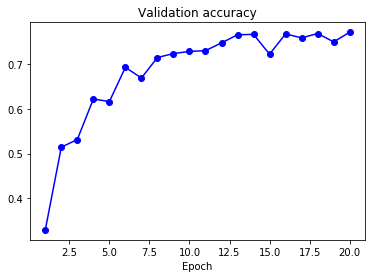

<Figure size 432x288 with 0 Axes>

In [11]:
rnn_val_acc = rnn_history.history['val_acc']
rnn_val_loss = rnn_history.history['val_loss']

epochs = range(1, len(rnn_val_acc) + 1)

plt.plot(epochs, rnn_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

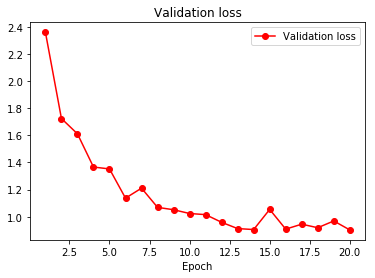

In [12]:
plt.clf()
plt.plot(epochs, rnn_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Estimate an RNN with an LSTM layer

In [15]:
from keras.layers import LSTM

rnn_lstm = Sequential()
rnn_lstm.add(Embedding(10000, 24, input_length = 100))
rnn_lstm.add(LSTM(24))
rnn_lstm.add(Dense(22, activation='softmax'))

rnn_lstm.compile(optimizer='rmsprop', 
                   loss='categorical_crossentropy', 
                   metrics=['acc'])
rnn_lstm.summary()

lstm_history = rnn_lstm.fit(x_train, y_train, epochs= 20, batch_size= 1024,
                         validation_data = (x_val, y_val))
rnn_lstm.save('lstm_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 24)           240000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_5 (Dense)              (None, 22)                550       
Total params: 245,254
Trainable params: 245,254
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 69649 samples
Epoch 1/20
278612/278612 [==============================] - 91s 328us/step - loss: 2.4751 - acc: 0.2459 - val_loss: 2.0953 - val_acc: 0.3445
Epoch 2/20
278612/278612 [==============================] - 67s 239us/step - loss: 1.8976 - acc: 0.4605 - val_loss: 1.6606 - val_acc: 0.5506
Epoch 3/20
278612/278612 [==============================] - 66s 239

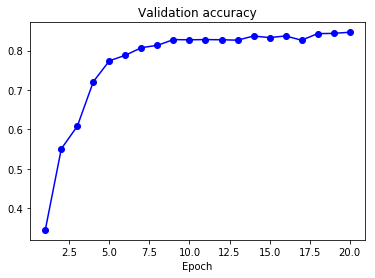

<Figure size 432x288 with 0 Axes>

In [16]:
lstm_val_acc = lstm_history.history['val_acc']
lstm_val_loss = lstm_history.history['val_loss']

epochs = range(1, len(lstm_val_acc) + 1)

plt.plot(epochs, lstm_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

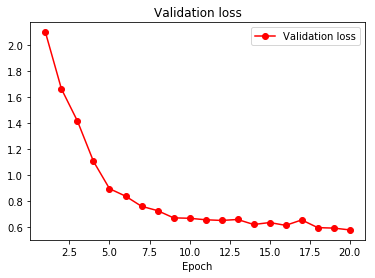

In [17]:
plt.clf()
plt.plot(epochs, lstm_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Estimate an RNN with a GRU layer

In [6]:
from keras.layers import GRU

gru = Sequential()
gru.add(Embedding(10000, 24, input_length = 100))
gru.add(GRU(24))
gru.add(Dense(22, activation='softmax'))

gru.compile(optimizer='rmsprop', 
                   loss='categorical_crossentropy', 
                   metrics=['acc'])
gru.summary()

gru_history = gru.fit(x_train, y_train, epochs= 20, batch_size= 1024,
                         validation_data = (x_val, y_val))
gru.save('grn_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 24)           240000    
_________________________________________________________________
gru_1 (GRU)                  (None, 24)                3528      
_________________________________________________________________
dense_2 (Dense)              (None, 22)                550       
Total params: 244,078
Trainable params: 244,078
Non-trainable params: 0
_________________________________________________________________
Train on 278612 samples, validate on 69649 samples
Epoch 1/20
278612/278612 [==============================] - 49s 176us/step - loss: 2.6081 - acc: 0.1888 - val_loss: 2.3626 - val_acc: 0.2563
Epoch 2/20
278612/278612 [==============================] - 48s 173us/step - loss: 2.1605 - acc: 0.3627 - val_loss: 1.9258 - val_acc: 0.4550
Epoch 3/20
278612/278612 [==============================] - 48s 173

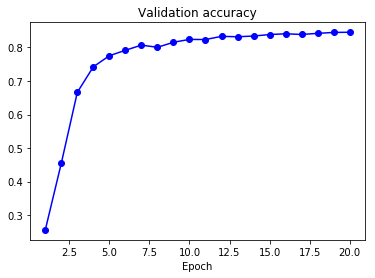

<Figure size 432x288 with 0 Axes>

In [7]:
gru_val_acc = gru_history.history['val_acc']
gru_val_loss = gru_history.history['val_loss']

epochs = range(1, len(gru_val_acc) + 1)

plt.plot(epochs, gru_val_acc, 'b', marker='o', label='Validation acc')
plt.title('Validation accuracy')
plt.xlabel("Epoch")
plt.figure()
plt.show()

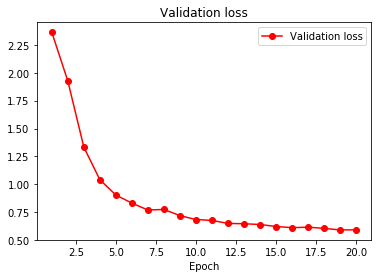

In [8]:
plt.clf()
plt.plot(epochs, gru_val_loss, 'r',marker = "o", label='Validation loss')
plt.title('Validation loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()